In [1]:
import matplotlib.pyplot as plt
plt.style.use('../note.mplstyle')
import numpy as np

In [2]:
from qutip import *

# Hamiltonian

$$
H_{lab} = \sum_{j=0}^{1}{\hbar\omega_{j}\frac{\sigma_{j}^{z}}{2}} 
- J_{01}\sigma_{0}^{z}\sigma_{1}^{z}
+ \sum_{j=0}^{1}{\hbar\Omega_{j}\cos{(\omega_{MW,j}t)}\sigma_{j}^{x}}
$$

$$
H_{rot}^{RWA} 
= \sum_{j=0}^{1}{\hbar(\omega_{j}-\omega_{MW,j})\frac{\sigma_{j}^{z}}{2}} 
- J_{01}\sigma_{0}^{z}\sigma_{1}^{z}
+ \sum_{j=0}^{1}{\hbar\Omega_{j}\frac{\sigma_{j}^{x}}{2}}
$$

In [3]:
w0 = 10 * 2 * np.pi # qubit frequency
w1 = 10 * 2 * np.pi

# J01 = 0.
# J_ratio = 0.01 # 0.005 # 0.01
# J = J_ratio * min(w0,w1) # 0. # J01 # 0.
# assert J >= 0.

g_ratio = 0.01
g = g_ratio * min(w0,w1)

# Omega_2J_ratio = 0.4 # 0.3 # 0.2 # 0.1 # 0.05 # 0.1
# Omega = Omega_2J_ratio * 2*J
from numpy import sqrt
Omega_g_ratio = 1/sqrt(3) # sqrt(3) # 1. # 0.5 # 0.31
Omega = Omega_g_ratio * g

# g = - J
del0 = g/2. # - 2.*g
del1 = 0.


# del0 = 2*J + Omega
# del1_del0_ratio = 3. # 1. # 1.5 # 2.1
# del1 = del1_del0_ratio * del0

# del0_ratio = 2.1 # 1.3
# del0 = del0_ratio*(-1)*(2*J)# 0.
# del1 = 0. # 2*J - Omega # 0.

# Omega = 2*J - del0 # 0.2 * J



wmw0 = w0 - del0 # w0
wmw1 = w1 - del1 # w1

wR0 = Omega # 0. # 0.3 * 2 * np.pi  # Rabi amplitude
wR1 = 0. # 0.3 * 2 * np.pi  # Rabi amplitude


w = np.array([w0, w1])
wR = np.array([wR0, wR1])
wmw = np.array([wmw0, wmw1])
dels = w - wmw
assert w.size == wR.size and w.size == wmw.size
N = w.size

In [4]:
dels_over_w = np.abs(dels / w) 
print(f"dels_over_w = {dels_over_w}")
assert np.all(dels_over_w < 1e-1)

dels_over_w = [0.005 0.   ]


In [5]:
wR_over_w = np.abs(wR / w)
print(f"wR_over_w = {wR_over_w}")
assert np.all(wR_over_w < 1e-1)

wR_over_w = [0.0057735 0.       ]


In [6]:
dels

array([0.31415927, 0.        ])

In [7]:
zero = Qobj(np.zeros((2,2)))

I, sigx, sigy, sigz = identity(2), sigmax(), sigmay(), sigmaz()

In [8]:
sigz_0 = tensor([sigz,I])
sigz_1 = tensor([I,sigz])
sigzlist = [sigz_0, sigz_1]

sigx_0 = tensor([sigx,I])
sigx_1 = tensor([I,sigx])
sigxlist = [sigx_0, sigx_1]

sigzsigz = tensor(sigz,sigz)

In [9]:
sigzlist[0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]]

In [10]:
sigxlist[0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]

In [11]:
w[1] - wmw[1]

0.0

In [12]:
del1

0.0

In [13]:
w[0] - wmw[0]

0.3141592653589811

In [14]:
del0

0.3141592653589793

In [15]:
options = Options(nsteps=20000)

H0 = tensor([zero,zero])
for j in range(N):
    H0 += (w[j]-wmw[j]) * (sigzlist[j]/2.) # + wR[j] * (sigxlist[j]/2.)
# H0 += (- J) * sigzsigz
H0 += (-g) * sigzsigz/(2*2)
    
Hdrive = tensor([zero,zero])
for j in range(N):
    Hdrive += wR[j] * (sigxlist[j]/2.)

# H0 = (- J01) * sigzsigz
# H += (- J01) * sigzsigz
H = H0 + Hdrive

In [16]:
T_pi = np.pi / (wR[0])

tmax = T_pi # 100 # 50 # 20 # 10. # T_pi # 10
t = np.linspace(0,tmax,201)

In [17]:
params = (f"w0-{w[0]:.4g}-w1-{w[1]:.4g}-wmw0-{wmw[0]:.4g}-wmw1"
          f"-{wmw[1]:.4g}-wR0-{wR[0]:.4g}-wR1-{wR[1]:.4g}-g-{g:.4g}-tmax-{tmax}")
params

'w0-62.83-w1-62.83-wmw0-62.52-wmw1-62.83-wR0-0.3628-wR1-0-g-0.6283-tmax-8.660254037844386'

In [18]:
sigzsigz

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0.  1.]]

In [19]:
sigzlist[0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]]

In [20]:
sigzlist[1]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]

In [21]:
# J
g

0.6283185307179586

In [22]:
H0

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.        ]
 [ 0.          0.31415927  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.31415927]]

In [23]:
eigvals = H0.eigenenergies()

eigvals

array([-0.31415927,  0.        ,  0.        ,  0.31415927])

[]

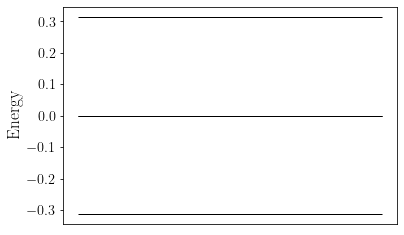

In [24]:
fig, ax = plt.subplots()

ax.hlines(eigvals, 0, 1, color='k', lw=1.)
ax.set_ylabel("Energy")
ax.xaxis.set_ticks([])
# fig.savefig(f"energy-levels-test-005-{params}.png")

In [25]:
Omega

0.3627598728468436

In [26]:
eigvals[3] - eigvals[2]

0.3141592653589802

In [27]:
eigvals[3] - eigvals[0]

0.6283185307179604

In [28]:
Omega

0.3627598728468436

In [29]:
# 2*J

In [30]:
del1

0.0

In [31]:
# abs(del1) - 2*J

In [32]:
eigvals

array([-0.31415927,  0.        ,  0.        ,  0.31415927])

# [TODO] Add rwa-free solution

In [33]:
E_00 = -(g/4) +(1/2.)*(-w[0]-w[1])
E_11 = -(g/4) +(1/2.)*(+w[0]+w[1])
E_01 = +(g/4) +(1/2.)*(-w[0]+w[1])
E_10 = +(g/4) +(1/2.)*(+w[0]-w[1])
eigval_labels = ("00","11","10","01")
for eigval, label in zip((E_00, E_11, E_10, E_01),eigval_labels):
    print(f"E_{label} = {eigval}")
eigvals_ana = np.array([E_00, E_11, E_10, E_01])
indices_sort = np.argsort(eigvals_ana)
# eigvals_ana.sort()
eigvals_ana[:] = eigvals_ana[indices_sort]
eigvals_labels_sorted = [eigval_labels[j_sort] for j_sort in indices_sort]

E_00 = -62.98893270447535
E_11 = 62.67477343911637
E_10 = 0.15707963267948966
E_01 = 0.15707963267948966


In [34]:
eigvals_ana

array([-62.9889327 ,   0.15707963,   0.15707963,  62.67477344])

In [35]:
eigvals_labels_sorted

['00', '10', '01', '11']

In [36]:
eigvals_ana - eigvals

array([-62.67477344,   0.15707963,   0.15707963,  62.36061417])

In [37]:
Omega

0.3627598728468436

In [38]:
eigvals[3] - eigvals[2]

0.3141592653589802

In [39]:
sigvec = [sigx,sigy,sigz]

c_ops = []

In [40]:
rho_00_00 = ket2dm(tensor([basis(2,1),basis(2,1)])) # ket2dm(tensor([basis(2,0),basis(2,0)]))

# rho_00_00

# fidelity(rho_00_00, rho_00_00)

# rho_t0 = rho_00_00

def fidel_00_00(t, rho):
#     _rho_00_00 = ket2dm(tensor([basis(2,0),basis(2,0)]))
    return fidelity(rho_00_00, rho)

# fidel_00_00(_, rho_00_00)

res_00_00 = mesolve(H, rho_00_00, t, c_ops, fidel_00_00, options=options)

assert not np.any(np.abs(np.imag(res_00_00.expect)).max() > 1e-15)
fidel_00_00_from_00_00 = np.real(res_00_00.expect)

In [41]:
rho_01_01 = ket2dm(tensor([basis(2,1),basis(2,0)])) # ket2dm(tensor([basis(2,0),basis(2,1)]))

# rho_t0 = rho_01_01

rho_11_11 = ket2dm(tensor([basis(2,0),basis(2,0)])) # ket2dm(tensor([basis(2,1),basis(2,1)]))
def fidel_11_11(t, rho):
#     rho_11_11 = ket2dm(tensor([basis(2,1),basis(2,1)]))
    global rho_11_11
    return fidelity(rho_11_11, rho)

res_01_01 = mesolve(H, rho_01_01, t, c_ops, options=options)

In [42]:
fidel_11_11_from_01_01 = np.empty_like(t, dtype=np.float64)
for jt, state in enumerate(res_01_01.states):
    fidel_11_11_from_01_01[jt] = fidelity(rho_11_11, state)

In [43]:
jt_max_fidel_11_11_from_01_01 = np.argmax(fidel_11_11_from_01_01)

In [44]:
np.abs(res_01_01.states[-1].data.toarray())

array([[9.99997713e-01, 0.00000000e+00, 1.04900787e-06, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.04900787e-06, 0.00000000e+00, 2.28701773e-06, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [45]:
rho_max_fidel_11_from_01 = res_01_01.states[jt_max_fidel_11_11_from_01_01].data.toarray()
rho_max_fidel_11_from_01_abs = np.abs(rho_max_fidel_11_from_01)

In [46]:
xx, yy = np.meshgrid(np.arange(4), np.arange(4))

In [47]:
zz = np.zeros_like(xx)

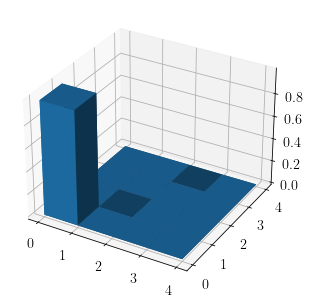

In [48]:
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(projection='3d')
ax.bar3d(xx.ravel(), yy.ravel(), zz.ravel(), 1, 1, rho_max_fidel_11_from_01_abs.ravel())
# fig.savefig(f"rho-abs-test-004-{params}.png")

In [49]:
np.linalg.svd(rho_max_fidel_11_from_01)

(array([[-1.00000000e+00+0.00000000e+00j,  1.04901267e-06+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,  0.00000000e+00-1.00000000e+00j],
        [ 0.00000000e+00+1.04901267e-06j,  0.00000000e+00+1.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          1.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j]]),
 array([9.99997713e-01, 2.28701663e-06, 0.00000000e+00, 0.00000000e+00]),
 array([[-1.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00-1.04901267e-06j, -0.00000000e+00+0.00000000e+00j],
        [ 1.04901267e-06+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00-1.00000000e+00j, -0.00000000e+00+0.00000000e+00j],
        [ 0.000000

In [50]:
fidelity(res_01_01.states[-1], res_01_01.states[-1]) - 1

2.220446049250313e-16

In [51]:
fidel_11_11_from_01_01.shape

(201,)

In [52]:
# assert not np.any(np.abs(np.imag(res_01_01.expect)).max() > 1e-15)
# fidel_11_11_from_01_01 = np.real(res_01_01.expect)

In [53]:
# res_01_01.states

In [54]:
rho_01_01 = ket2dm(tensor([basis(2,1),basis(2,0)]))
rho_11_11 = ket2dm(tensor([basis(2,0),basis(2,0)]))

def fidel_01_01(t, rho):
    global rho_01_01
    return fidelity(rho_01_01, rho)

res_11_11 = mesolve(H, rho_11_11, t, c_ops, fidel_01_01, options=options)

assert not np.any(np.abs(np.imag(res_11_11.expect)).max() > 1e-15)
fidel_01_01_from_11_11 = np.real(res_11_11.expect)

In [55]:
rho_10_10 = ket2dm(tensor([basis(2,0),basis(2,1)]))

def fidel_10_10(t, rho):
    global rho_10_10
    return fidelity(rho_10_10, rho)

res_10_10 = mesolve(H, rho_10_10, t, c_ops, fidel_10_10, options=options)

assert not np.any(np.abs(np.imag(res_10_10.expect)).max() > 1e-15)
fidel_10_10_from_10_10 = np.real(res_10_10.expect)

In [57]:
ket_11 = tensor([basis(2,0), basis(2,0)])
ket_01 = tensor([basis(2,1), basis(2,0)])

# ket_01_plus_11 = (1/2**0.5) * ket_11 + (1/2**0.5) * ket_01

ket_00 = tensor([basis(2,1), basis(2,1)])
ket_00_plus_01 = (1/2**0.5) * ket_00 + (1/2**0.5) * ket_01

rho_00_plus_01 = ket2dm(ket_00_plus_01)

ket_00_plus_11 = (1/2**0.5) * ket_00 + (1/2**0.5) * ket_11

rho_00_plus_11 = ket2dm(ket_00_plus_11)

rho_00_plus_11

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]

In [58]:
rho_00_plus_01

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.5 0.5]]

In [59]:
ket_00_plus_01

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.        ]
 [0.        ]
 [0.70710678]
 [0.70710678]]

In [62]:
# rho_01_plus_11 = ket2dm(ket_01_plus_11)
# rho_01_plus_11

In [63]:
fidel_00_plus_11 = lambda t, rho: np.real(fidelity(rho_00_plus_11, rho))

res_from_00_plus_01 = mesolve(H, rho_00_plus_01, t, c_ops, fidel_00_plus_11, options=options)

fidel_00_plus_11_from_00_plus_01 = res_from_00_plus_01.expect

sq_fidel_00_plus_11_from_00_plus_01 = np.square(fidel_00_plus_11_from_00_plus_01)

# [TODO] Compare the `fidelity()` function in `qutip` and the analytical calculation for some density operators

# --> From the source code, the fidelity is
$$
F(\rho,\sigma) = Tr\left[\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}}\right]
$$

In [66]:
fidel_stack = np.empty((4,t.size))
fidel_stack[0,:] = fidel_11_11_from_01_01
fidel_stack[1,:] = fidel_10_10_from_10_10
fidel_stack[2,:] = fidel_01_01_from_11_11
fidel_stack[3,:] = fidel_00_00_from_00_00

In [67]:
sq_fidel_stack = np.square(fidel_stack)

In [68]:
wR

array([0.36275987, 0.        ])

In [69]:
g

0.6283185307179586

In [70]:
wR[0]

0.3627598728468436

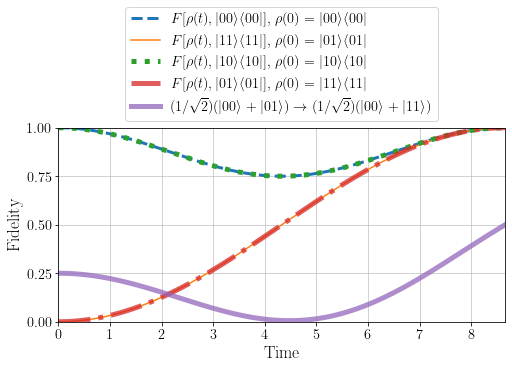

In [72]:
fig, ax = plt.subplots(ncols=1, figsize=(7,5), constrained_layout=True, 
#                          gridspec_kw=dict(width_ratios=[3,1])
                      )

# ax = axes[0]
l_00_from_00, = ax.plot(t, sq_fidel_stack[3,:], lw=3, ls='--')
l_11_from_01, = ax.plot(t, sq_fidel_stack[0,:])
l_10_from_10, = ax.plot(t, sq_fidel_stack[1,:], lw=5, ls=':')
l_01_from_11, = ax.plot(t, sq_fidel_stack[2,:], lw=5, ls='-.', alpha=0.75)
l_00_plus_11_from_00_plus_01, = ax.plot(t, sq_fidel_00_plus_11_from_00_plus_01, lw=5, ls='-', alpha=0.75)

ax.set_xlim(t[[0,-1]])
ax.set_xlabel(r"Time")
ax.set_ylabel("Fidelity")
ax.legend(
    [l_00_from_00, l_11_from_01, l_10_from_10, l_01_from_11, l_00_plus_11_from_00_plus_01], 
    [r"$F[\rho(t), |00\rangle\langle 00|]$, $\rho(0)=|00\rangle\langle 00|$", 
     r"$F[\rho(t), |11\rangle\langle 11|]$, $\rho(0)=|01\rangle\langle 01|$",
     r"$F[\rho(t), |10\rangle\langle 10|]$, $\rho(0)=|10\rangle\langle 10|$",
     r"$F[\rho(t), |01\rangle\langle 01|]$, $\rho(0)=|11\rangle\langle 11|$",
     r"$(1/\sqrt{2})(|00\rangle+|01\rangle) \rightarrow (1/\sqrt{2})(|00\rangle+|11\rangle)$",
    ],
    loc='lower center',
    bbox_to_anchor=(0.5,1)
)
ax.yaxis.set_ticks([0,0.25,0.5,0.75,1])
ax.grid(True, alpha=0.75, lw=0.75)
ax.set_axisbelow(True)


# l_10_from_10.set_visible(False)
# l_11_from_01.set_visible(False)
# l_01_from_11.set_visible(False)
ax.set_ylim(0,1)


# ax = axes[1]
# ax.hlines(eigvals, 0, 1, color='k', lw=1.)
# for eigval, label in zip(eigvals_ana, eigvals_labels_sorted):
#     ax.text(1.02, eigval, fr"$|{label}\rangle$", va='center', ha='left', fontsize='large')
# ax.set_xlim(-0.1,1.4)
# ax.set_ylabel("Energy")
# ax.xaxis.set_ticks([])

# fig.savefig(f"fidelities-test-049-{params}.svg")

In [73]:
sq_fidel_stack[:,-1]

array([0.99999771, 1.00000006, 0.99999771, 1.00000006])

In [74]:
fidel_11_11_from_01_01.max()

0.9999988564904821

In [75]:
1/2**0.5

0.7071067811865475